In [21]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import pandas as pd

trades_df = pd.read_csv('/content/drive/MyDrive/AnythingAI/historical_data.csv')
sentiment_df = pd.read_csv('/content/drive/MyDrive/AnythingAI/fear_greed_index.csv')


In [24]:
trades_df['Date'] = pd.to_datetime(trades_df['Timestamp'], unit='ms').dt.date

sentiment_df['Date'] = pd.to_datetime(sentiment_df['date']).dt.date

sentiment_small = sentiment_df[['Date', 'classification', 'value']]

merged_df = pd.merge(
    trades_df,
    sentiment_small,
    on='Date',
    how='left'
)

merged_df[['Date','classification']].head()


,Date,classification
0,2024-10-27,Greed
1,2024-10-27,Greed
2,2024-10-27,Greed
3,2024-10-27,Greed
4,2024-10-27,Greed


In [25]:
# keep only rows where sentiment exists
analysis_df = merged_df.dropna(subset=['classification']).copy()

# standardize column names we will use
analysis_df.rename(columns={
    'Account': 'account',
    'Side': 'side',
    'Closed PnL': 'closed_pnl',
    'Size USD': 'size_usd'
}, inplace=True)

# daily aggregation per trader and sentiment
daily_features = (
    analysis_df
    .groupby(['account', 'Date', 'classification'])
    .agg(
        daily_pnl = ('closed_pnl', 'sum'),
        avg_trade_size = ('size_usd', 'mean'),
        trade_count = ('size_usd', 'count'),
        buy_ratio = ('side', lambda x: (x == 'BUY').mean())
    )
    .reset_index()
)

daily_features.head()


,account,Date,classification,daily_pnl,avg_trade_size,trade_count,buy_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,Greed,-3.275059e+05,14810.891818,462,0.300866
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,Fear,1.927736e+06,16345.241940,3356,0.468415
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,Greed,2.060745e+04,2492.749906,320,0.453125
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,Fear,1.709873e+04,1693.351684,3533,0.432494
4,0x271b280974205ca63b716753467d5a371de622ab,2024-07-03,Neutral,-1.000000e+00,6070.200000,5,0.400000


In [26]:
daily_features.shape


(77, 7)

In [27]:
# create trader-level average size
trader_size = (
    daily_features
    .groupby('account')['avg_trade_size']
    .mean()
)

# define thresholds
q25 = trader_size.quantile(0.25)
q75 = trader_size.quantile(0.75)

def segment_trader(x):
    if x >= q75:
        return 'Whale'
    elif x <= q25:
        return 'Retail'
    else:
        return 'Mid'

daily_features['segment'] = daily_features['account'].map(
    trader_size
).apply(segment_trader)

daily_features[['account','segment']].drop_duplicates().head()


,account,segment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,Whale
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,Retail
4,0x271b280974205ca63b716753467d5a371de622ab,Whale
7,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,Retail
9,0x2c229d22b100a7beb69122eed721cee9b24011dd,Mid


In [28]:
sentiment_summary = (
    daily_features
    .groupby(['segment','classification'])
    .agg(
        avg_daily_pnl = ('daily_pnl','mean'),
        avg_leverage_proxy = ('avg_trade_size','mean'),
        avg_trades = ('trade_count','mean')
    )
    .reset_index()
)

sentiment_summary


,segment,classification,avg_daily_pnl,avg_leverage_proxy,avg_trades
0,Mid,Extreme Greed,-985.707128,3941.543861,1063.666667
1,Mid,Fear,173769.713249,3760.506270,3005.687500
2,Mid,Greed,110303.769316,4364.943417,327.882353
3,Mid,Neutral,48464.969756,3319.936451,502.750000
4,Retail,Extreme Greed,187842.084190,3677.809106,3041.000000
5,Retail,Fear,52118.070496,1170.124427,7742.500000
6,Retail,Greed,140526.245306,1469.835966,3458.375000
7,Retail,Neutral,-4562.497302,403.644777,1908.000000
8,Whale,Extreme Greed,-7919.471032,6219.798493,730.000000
9,Whale,Fear,437833.151827,15014.953924,2980.000000


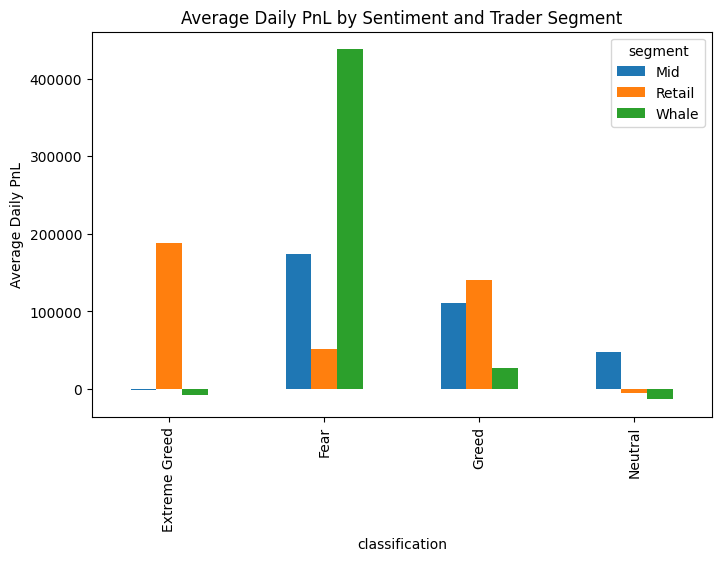

In [29]:
import matplotlib.pyplot as plt

pivot = sentiment_summary.pivot(
    index='classification',
    columns='segment',
    values='avg_daily_pnl'
)

pivot.plot(kind='bar', figsize=(8,5))
plt.title("Average Daily PnL by Sentiment and Trader Segment")
plt.ylabel("Average Daily PnL")
plt.show()


In [30]:
daily_features.groupby('classification')['avg_trade_size'].mean()


,avg_trade_size
classification,
Extreme Greed,4344.447836
Fear,5926.522723
Greed,5839.310974
Neutral,3793.444161


## Insights

From the analysis, trader performance clearly varies across sentiment regimes.
Whale traders show the strongest profitability during Fear, indicating better positioning in stressed markets.
Retail traders perform relatively better during Extreme Greed, but their performance becomes weak in neutral conditions.
Across all traders, the average trade size is higher during Fear (≈5926) and Greed (≈5839) compared to Neutral (≈3793) and Extreme Greed (≈4344).
This suggests traders tend to take larger positions when market sentiment is strongly directional.
However, higher trade size does not always translate to higher profits, especially for retail traders.
Overall, the results indicate that market sentiment significantly influences both risk-taking behavior and profitability.

## Limitation

The usable sample is small (77 daily records) because sentiment data does not fully overlap with the trading period.